In [37]:
#Raster auf Ötztal zuschneiden
import os
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.enums import Resampling
from rasterio.windows import from_bounds
from shapely.geometry import box

def clip_and_match_raster(input_path, reference_path, output_path):
    with rasterio.open(reference_path) as ref:
        reference_bounds = ref.bounds
        reference_transform = ref.transform
        reference_shape = (ref.height, ref.width)
        reference_crs = ref.crs

    with rasterio.open(input_path) as src:
        # Erstelle ein Polygon aus den Referenzgrenzen
        ref_polygon = [box(*reference_bounds)]

        # Schneiden mit der Bounding Box
        out_image, out_transform = mask(src, ref_polygon, crop=True)

        # Sicherstellen, dass die Dimensionen genau übereinstimmen
        new_image = rasterio.enums.Resampling.nearest
        aligned_image = rasterio.vrt.WarpedVRT(
            src,
            crs=reference_crs,
            transform=reference_transform,
            width=reference_shape[1],
            height=reference_shape[0],
            resampling=Resampling.nearest
        )

        # Metadaten für das zugeschnittene Raster übernehmen und anpassen
        out_meta = src.meta.copy()
        out_meta.update({
            "height": reference_shape[0],
            "width": reference_shape[1],
            "transform": reference_transform
        })

        # Speichere das exakte zugeschnittene Raster
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(aligned_image.read())

# Pfade definieren
input_folder = "C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2021/GLF_2021_T32TPS/OG/OG"  # Ordner mit den Original-Rastern
reference_raster_path = "C:/Users/anne_/Desktop/Anne/ENVEO/10dem.tif"  # Referenzraster

# Alle Raster im Ordner verarbeiten
for file_name in os.listdir(input_folder):
    if file_name.endswith(".tif"):  # Nur TIFF-Dateien bearbeiten
        input_path = os.path.join(input_folder, file_name)
        
        # Neuen Dateinamen mit den ersten 23 Zeichen erstellen
        output_name = f"{file_name[:23]}.tif"
        output_path = os.path.join(input_folder, output_name)
        
        # Raster zuschneiden und anpassen
        clip_and_match_raster(input_path, reference_raster_path, output_path)
        print(f"Zugeschnittenes Raster gespeichert als: {output_name}")


Zugeschnittenes Raster gespeichert als: GLF_S2A_MSIL1C_20210503.tif
Zugeschnittenes Raster gespeichert als: GLF_S2A_MSIL1C_20210526.tif
Zugeschnittenes Raster gespeichert als: GLF_S2A_MSIL1C_20210615.tif
Zugeschnittenes Raster gespeichert als: GLF_S2A_MSIL1C_20210622.tif
Zugeschnittenes Raster gespeichert als: GLF_S2A_MSIL1C_20210702.tif
Zugeschnittenes Raster gespeichert als: GLF_S2A_MSIL1C_20210712.tif
Zugeschnittenes Raster gespeichert als: GLF_S2A_MSIL1C_20210811.tif
Zugeschnittenes Raster gespeichert als: GLF_S2A_MSIL1C_20210814.tif
Zugeschnittenes Raster gespeichert als: GLF_S2A_MSIL1C_20210821.tif
Zugeschnittenes Raster gespeichert als: GLF_S2A_MSIL1C_20210903.tif
Zugeschnittenes Raster gespeichert als: GLF_S2A_MSIL1C_20210910.tif
Zugeschnittenes Raster gespeichert als: GLF_S2A_MSIL1C_20210913.tif
Zugeschnittenes Raster gespeichert als: GLF_S2A_MSIL1C_20210920.tif
Zugeschnittenes Raster gespeichert als: GLF_S2A_MSIL1C_20210923.tif
Zugeschnittenes Raster gespeichert als: GLF_S2A_

In [19]:
# Binärraster aus Band 1 Werte 1&2 der Schneeklassifikation
import rasterio
import numpy as np
import os
import re  # Importiere Regex-Modul, um das Datum zu extrahieren

# Definiere den Ordnerpfad, in dem die Schneeklassifikations-Raster gespeichert sind
input_folder = "C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2021/GLF_2021_T32TPS"  # Ordnerpfad anpassen

# Definiere den Ordnerpfad, in dem die binären .tif-Raster gespeichert werden sollen
output_folder = "C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2021/GLF_2021_T32TPS/binary"  # Ordnerpfad anpassen

# Stelle sicher, dass der Ausgabeordner existiert
os.makedirs(output_folder, exist_ok=True)

# Liste der .tif-Dateien im Eingabeordner
raster_files = [f for f in os.listdir(input_folder) if f.endswith('.tif')]

# Iteriere über alle Raster-Dateien im Ordner
for raster_file in raster_files:
    input_path = os.path.join(input_folder, raster_file)
    
    # Öffne das Raster mit rasterio
    with rasterio.open(input_path) as src:
        # Lese das erste Band (Werte 0, 1, 2, 3, 4, 5, 255)
        band_data = src.read(1)

        # Erstelle eine binäre Maske: Werte 1 und 2 werden zu 1, alle anderen zu 0
        binary_mask = np.where((band_data == 1) | (band_data == 2), 1, 0)

        # Extrahiere das Datum aus dem Dateinamen (im Format YYYYMMDD)
        match = re.search(r'(\d{8})', raster_file)  # Sucht nach 8 Ziffern im Dateinamen
        if match:
            date_str = match.group(1)  # Datum im Format YYYYMMDD extrahieren
        else:
            raise ValueError(f"Datum im Dateinamen nicht gefunden: {raster_file}")

        # Definiere den Dateinamen für das binäre Raster
        output_file_name = f"SC_{date_str}.tif"  # Benennung nach SC_YYYYMMDD.tif
        output_path = os.path.join(output_folder, output_file_name)

        # Definiere die Metadaten für das Raster
        metadata = {
            'driver': 'GTiff',
            'count': 1,  # Einzelschicht für binäre Maske
            'dtype': 'uint8',  # Binäre Werte (0 oder 1)
            'crs': src.crs,  # Beibehalten der Projektion (EPSG:32632)
            'width': src.width,  # Anzahl der Spalten
            'height': src.height,  # Anzahl der Zeilen
            'count': 1,  # Eine Schicht
            'nodata': 0,  # Kein Datenwert
            'transform': src.transform  # Beibehalten der Transformation (10 m Auflösung)
        }

        # Speichern des binären Rasterbildes als .tif
        with rasterio.open(output_path, 'w', **metadata) as dst:
            dst.write(binary_mask, 1)  # Schreibe die Maske in den ersten (und einzigen) Band

        # Ausgabe der Dateiinformationen
        print(f"Saved binary snow cover raster as {output_path}")            


Saved binary snow cover raster as C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2021/GLF_2021_T32TPS/binary\SC_20210503.tif
Saved binary snow cover raster as C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2021/GLF_2021_T32TPS/binary\SC_20210526.tif
Saved binary snow cover raster as C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2021/GLF_2021_T32TPS/binary\SC_20210615.tif
Saved binary snow cover raster as C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2021/GLF_2021_T32TPS/binary\SC_20210622.tif
Saved binary snow cover raster as C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2021/GLF_2021_T32TPS/binary\SC_20210702.tif
Saved binary snow cover raster as C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2021/GLF_2021_T32TPS/binary\SC_20210712.tif
Saved binary snow cover raster as C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2021/GLF_2021_T32TPS/binary\SC_20210811.tif
Saved binary snow cover raster as C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2021/GLF_2021_T32TPS/binary\SC_20210814.tif
Saved binary snow cover raster as C:/Use

In [20]:
# Snowline für HEF, HJF, KWF und Gepatsch über glacier selection
import xarray as xr
import rasterio
import numpy as np
import pandas as pd
import os
from rasterio import Affine
from rasterio.enums import Resampling
import pandas as pd
import matplotlib.pyplot as plt
# ------------------------------
# 1) Parameter und Pfade anpassen
# ------------------------------
input_folder = r'C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2021/GLF_2021_T32TPS/binary'  # Ordner mit Schneebedeckungsrastern
dem_file = r'C:/Users/anne_/Desktop/Anne/ENVEO/10dem.tif'  # Pfad zum DEM
glacier_mask_file = r'C:/Users/anne_/Desktop/Anne/ENVEO/10glacierselection.tiff'  # Pfad zur „Glacier Selection“-Datei

# IDs deiner Gletscher: 
# (Die Werte sollten exakt mit denen übereinstimmen, die im Raster hinterlegt sind.)
GLACIER_IDS = [755560, 755530, 755531, 755612]

# ------------------------------
# 2) Hilfsfunktionen
# ------------------------------

def calculate_snow_coverage(snow_cover_sub, dem_sub, elevation_bin, bin_width=20):
    """
    Berechnet den prozentualen Anteil an Schnee (==1) in einem bestimmten Höhenintervall.
    snow_cover_sub und dem_sub sind bereits auf einen Gletscherbereich gefiltert (per np.where).
    elevation_bin: unteres Intervall, bin_width: Größe des Intervalls
    """
    bin_mask = (dem_sub >= elevation_bin) & (dem_sub < elevation_bin + bin_width)
    total_pixels = np.sum(bin_mask)
    if total_pixels == 0:
        return 0.0
    # Da die Arrays NaN für alle Nicht-Gletscher-Pixel haben, filtern wir diese aus:
    snow_pixels = np.sum((snow_cover_sub[bin_mask] == 1) & ~np.isnan(snow_cover_sub[bin_mask]))
    return (snow_pixels / total_pixels) * 100.0


def find_snowline(dem_sub, snow_cover_sub, bin_width=20):
    """
    Bestimmt die Snow Line (SLA) in einem bereits auf einen Gletscher-Subset gefilterten
    dem_sub und snow_cover_sub. Gibt einen Höhenbereich (tuples) zurück.
    
    Suchlogik:
    - Zuerst wird nach 5 aufeinander folgenden Bins >50% geschaut,
    - sonst 4 Bins,
    - sonst 3 Bins,
    - sonst 1 Bin.
    """
    # min-/max-Höhe nur über den Gletscherbereich bestimmen
    min_elevation = np.nanmin(dem_sub)
    max_elevation = np.nanmax(dem_sub)

    # Falls das Gletscher-Areal leer oder nur NaNs ist:
    if np.isnan(min_elevation) or np.isnan(max_elevation):
        return None
    
    # Iteration in Schritten von bin_width (z. B. 20 m)
    for elevation_bin in range(int(min_elevation), int(max_elevation)+1, bin_width):
        # Berechne Schneebedeckung für die nächsten 5 Bins
        snow_coverage = []
        for i in range(5):
            current_bin = elevation_bin + i * bin_width
            if current_bin < max_elevation:
                coverage = calculate_snow_coverage(snow_cover_sub, dem_sub, current_bin, bin_width)
                snow_coverage.append(coverage)
            else:
                break

        # 5 Bins > 50%
        if len(snow_coverage) >= 5 and all(sc > 50 for sc in snow_coverage[:5]):
            return (elevation_bin, elevation_bin + 4 * bin_width)
        # 4 Bins > 50%
        elif len(snow_coverage) >= 4 and all(sc > 50 for sc in snow_coverage[:4]):
            return (elevation_bin, elevation_bin + 3 * bin_width)
        # 3 Bins > 50%
        elif len(snow_coverage) >= 3 and all(sc > 50 for sc in snow_coverage[:3]):
            return (elevation_bin, elevation_bin + 2 * bin_width)
    
    # Keine 3-5 aufeinanderfolgenden Bins gefunden -> Schau nach einzelnen Bins > 50%
    for elevation_bin in range(int(min_elevation), int(max_elevation)+1, bin_width):
        coverage = calculate_snow_coverage(snow_cover_sub, dem_sub, elevation_bin, bin_width)
        if coverage > 50:
            return (elevation_bin, elevation_bin)
    
    # Gar nicht gefunden
    return None
# ------------------------------
# 3) Hauptfunktion
# ------------------------------

def process_snow_cover_files_multiple_glaciers(input_folder, dem_file, glacier_mask_file, glacier_ids):
    """
    Liest das DEM, die „Glacier Selection“-Datei und alle Schneebedeckungs-Raster ein.
    Für jeden Zeitschritt (Snow-Cover-Datei) und jeden Gletscher (ID) wird die Snow Line bestimmt.
    Ergebnisse werden in separaten CSV-Dateien pro Gletscher-ID gespeichert.
    """
    # 1) DEM einlesen
    with rasterio.open(dem_file) as dem_src:
        dem_array = dem_src.read(1)
    
    # 2) Glacier-Mask einlesen
    with rasterio.open(glacier_mask_file) as glacier_src:
        glacier_mask_array = glacier_src.read(1)

    # 3) Liste aller Schneebedeckungsdateien
    snow_cover_files = [f for f in os.listdir(input_folder) 
                        if f.endswith('.tif') and f.startswith('SC_')]

    # Erstelle ein Dictionary, in dem pro Gletscher-ID eine leere Liste steht,
    # um die Ergebnisse zu sammeln
    results_by_glacier = {gid: [] for gid in glacier_ids}

    # 4) Iteration über jede Schneebedeckungsdatei
    for snow_cover_file in snow_cover_files:
        file_path = os.path.join(input_folder, snow_cover_file)
        print(f"Processing {snow_cover_file}...")
        
        # Extrahiere das Datum aus dem Dateinamen (Format: SC_YYYYMMDDHEF.tif)
        date_str = snow_cover_file[3:11]  # z. B. '20210715'
        
        # 4a) Snow Cover Array einlesen
        with rasterio.open(file_path) as sc_src:
            snow_cover_array = sc_src.read(1)

        # 4b) Für jede Gletscher-ID Snow Line berechnen
        for gid in glacier_ids:
            # Erzeuge eine Maske nur für diesen Gletscher
            glacier_mask = (glacier_mask_array == gid)
            
            # Filtere DEM und Snow-Cover-Array auf diesen Gletscher:
            # überall sonst np.nan
            dem_sub = np.where(glacier_mask, dem_array, np.nan)
            snow_sub = np.where(glacier_mask, snow_cover_array, np.nan)
            
            # Snowline bestimmen
            sla_range = find_snowline(dem_sub, snow_sub, bin_width=20)
            
            if sla_range:
                # z. B. (2800, 2880)
                sla_str = f"{sla_range[0]} - {sla_range[1]}"
            else:
                sla_str = "No SLA found"
            
            # Ergebnis merken
            results_by_glacier[gid].append({
                "Date": date_str,
                "SnowCoverFile": snow_cover_file,
                "SLA Range (m)": sla_str
            })
    
    # 5) Ergebnisse in separaten CSVs pro Glacier-ID speichern
    for gid, results_list in results_by_glacier.items():
        df = pd.DataFrame(results_list)
        out_csv = os.path.join(input_folder, f"snowline_results_{gid}.csv")
        df.to_csv(out_csv, index=False)
        print(f"Ergebnisse für Gletscher {gid} gespeichert in: {out_csv}")

# ------------------------------
# 4) Skript ausführen
# ------------------------------
if __name__ == "__main__":
    process_snow_cover_files_multiple_glaciers(
        input_folder=input_folder,
        dem_file=dem_file,
        glacier_mask_file=glacier_mask_file,
        glacier_ids=GLACIER_IDS
    )


Processing SC_20210503.tif...
Processing SC_20210508.tif...
Processing SC_20210526.tif...
Processing SC_20210528.tif...
Processing SC_20210531.tif...
Processing SC_20210615.tif...
Processing SC_20210617.tif...
Processing SC_20210622.tif...
Processing SC_20210627.tif...
Processing SC_20210702.tif...
Processing SC_20210710.tif...
Processing SC_20210712.tif...
Processing SC_20210720.tif...
Processing SC_20210806.tif...
Processing SC_20210809.tif...
Processing SC_20210811.tif...
Processing SC_20210814.tif...
Processing SC_20210819.tif...
Processing SC_20210821.tif...
Processing SC_20210826.tif...
Processing SC_20210903.tif...
Processing SC_20210905.tif...
Processing SC_20210910.tif...
Processing SC_20210913.tif...
Processing SC_20210918.tif...
Processing SC_20210920.tif...
Processing SC_20210923.tif...
Processing SC_20210925.tif...
Processing SC_20210928.tif...
Processing SC_20210930.tif...
Ergebnisse für Gletscher 755560 gespeichert in: C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2021/GLF_2

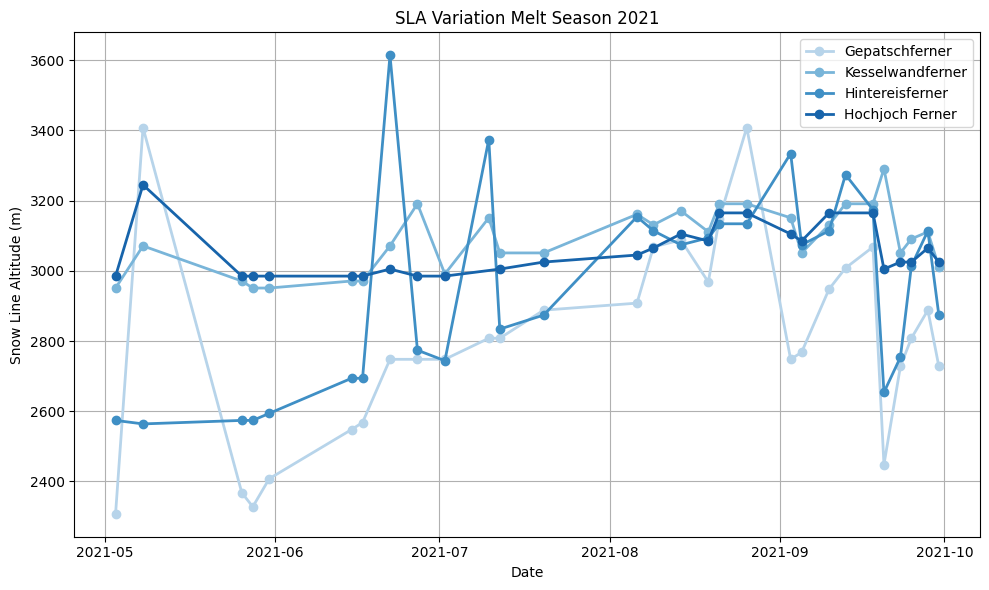

In [21]:
# Berechnung des SLA Plots für die vier Gletscher
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# -------------------------------
# 1) Parameter: Pfade & Gletscher-IDs
# -------------------------------
input_folder = r"C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2021/GLF_2021_T32TPS/binary"  # Ordner mit CSVs
output_path = r"C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2021/SLA_2021.png"      # Speicherpfad für die Grafik

# Gletscher-IDs und zugehörige Namen:
gid_to_name = {
    755530: "Gepatschferner",
    755560: "Kesselwandferner",
    755531: "Hintereisferner",
    755612: "Hochjoch Ferner"
}
gids = list(gid_to_name.keys())

# -------------------------------
# 2) Farben definieren
# -------------------------------
num_glaciers = len(gids)
blues = cm.Blues(np.linspace(0.3, 0.8, num_glaciers))  # 4 Blautöne von hell bis dunkel

# -------------------------------
# 3) Plot erstellen
# -------------------------------
plt.figure(figsize=(10, 6))

for i, gid in enumerate(gids):
    csv_file = os.path.join(input_folder, f"snowline_results_{gid}.csv")

    # CSV einlesen
    df = pd.read_csv(csv_file)

    # Zeilen mit "No SLA found" ausschließen
    df = df[df["SLA Range (m)"] != "No SLA found"]
    if df.empty:
        print(f"Keine gültigen SLA-Daten für Gletscher {gid} in '{csv_file}'.")
        continue

    # SLA-Min / -Max extrahieren
    df["SLA_min"] = df["SLA Range (m)"].str.split(" - ").str[0].astype(float)
    df["SLA_max"] = df["SLA Range (m)"].str.split(" - ").str[1].astype(float)
    df["SLA_mid"] = (df["SLA_min"] + df["SLA_max"]) / 2

    # Datum parsen (Format: YYYYMMDD)
    df["Date"] = pd.to_datetime(df["Date"], format="%Y%m%d")

    # Sortierung nach Datum
    df.sort_values(by="Date", inplace=True)

    # Plot: Linien ohne Marker, Farbe aus 'blues'
    plt.plot(
        df["Date"], 
        df["SLA_mid"],
        color=blues[i],
        linestyle="-",
        linewidth=2,
        marker="o",
        label=gid_to_name[gid]  # <-- Statt Gletscher-ID jetzt den Namen anzeigen
    )

# -------------------------------
# 4) Diagramm-Details & Speichern
# -------------------------------
plt.xlabel("Date")
plt.ylabel("Snow Line Altitude (m)")
plt.title("SLA Variation Melt Season 2021")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Grafik speichern (z. B. als PNG in hoher Auflösung)
plt.savefig(output_path, dpi=300)

# Optional: Plot anzeigen
plt.show()

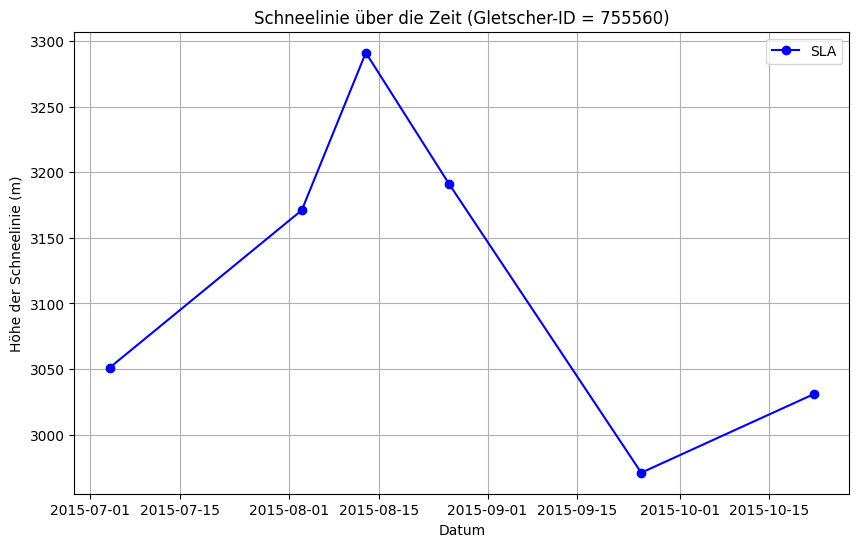

In [40]:
# Abbildung pro Gletscher

# 1) CSV einlesen (Dateiname anpassen)
df = pd.read_csv("C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2016/GLF_2016_T32TPS/binary/snowline_results_755560.csv")

#2) Zeilen mit "No SLA found" aussortieren
df = df[df["SLA Range (m)"] != "No SLA found"]

# 3) SLA-Min und -Max aus dem String extrahieren
df["SLA_min"] = df["SLA Range (m)"].str.split(" - ").str[0].astype(float)
df["SLA_max"] = df["SLA Range (m)"].str.split(" - ").str[1].astype(float)

# 4) Mittlere SLA-Höhe berechnen
df["SLA_mid"] = (df["SLA_min"] + df["SLA_max"]) / 2

# 5) Datum in ein DateTime-Format bringen
#    Falls dein Datumsstring ein anderes Format hat, hier anpassen (z. B. "%Y%m%d" oder "%d.%m.%Y" etc.)
df["Date"] = pd.to_datetime(df["Date"], format="%Y%m%d")

# 6) Nach Datum sortieren
df.sort_values(by="Date", inplace=True)

# 7) Liniendiagramm plotten
plt.figure(figsize=(10, 6))
plt.plot(df["Date"], df["SLA_mid"], marker="o", linestyle="-", color="b", label="SLA")
plt.xlabel("Datum")
plt.ylabel("Höhe der Schneelinie (m)")
plt.title("Schneelinie über die Zeit (Gletscher-ID = 755560)")
plt.grid(True)
plt.legend()
plt.show()


In [22]:
# Zusammenführen der CSVs aller Jahre pro Gletscher in 4 CSV
import os
import pandas as pd

# -------------------------------
# 1) Eingabeparameter
# -------------------------------
# Liste der Ordnerpfade, in denen die CSV-Dateien liegen
input_folders = [
    "C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2015/GLF_2015_T32TPS/binary",
    "C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2016/GLF_2016_T32TPS/binary",  # Ersetze durch den tatsächlichen Pfad
    "C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2017/GLF_2017_T32TPS/binary", 
    "C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2018/GLF_2018_T32TPS/binary",  # Ersetze durch den tatsächlichen Pfad
    "C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2019/GLF_2019_T32TPS/binary", 
    "C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2020/GLF_2020_T32TPS/binary",  # Ersetze durch den tatsächlichen Pfad
    "C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2021/GLF_2021_T32TPS/binary"  # Ersetze durch den tatsächlichen Pfad
]

# -------------------------------
# 2) Gletscher-IDs
# -------------------------------
gids = [755530, 755531, 755560, 755612]  # Gletscher-IDs

# -------------------------------
# 3) Iteration und Zusammenführung
# -------------------------------

# Erstelle ein Dictionary für jede Gletscher-ID, um die CSV-Dateien zu speichern
final_dfs = {gid: pd.DataFrame() for gid in gids}

# Iteriere über alle Ordnerpfade
for folder in input_folders:
    # Iteriere über die Gletscher-IDs
    for gid in gids:
        # Erstelle den Dateipfad für die aktuelle CSV-Datei
        csv_file = os.path.join(folder, f"snowline_results_{gid}.csv")

        if os.path.exists(csv_file):
            # Lese die CSV-Datei
            df = pd.read_csv(csv_file)

            # Optional: Du könntest eine zusätzliche Spalte für das Jahr oder den Pfad hinzufügen
            # df["Year"] = os.path.basename(folder)  # Zum Beispiel das Jahr als Spalte hinzufügen

            # Füge die Daten der aktuellen CSV-Datei zum entsprechenden Gletscher im finalen DataFrame hinzu
            final_dfs[gid] = pd.concat([final_dfs[gid], df], ignore_index=True)
        else:
            print(f"Datei nicht gefunden: {csv_file}")

# -------------------------------
# 4) Speichern der finalen CSV-Dateien für jeden Gletscher
# -------------------------------
output_folder = "C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/all SLA csv"  # Ersetze durch deinen gewünschten Zielpfad

for gid, final_df in final_dfs.items():
    # Definiere den Speicherpfad für die finale CSV-Datei
    output_filename = f"snowline_results_{gid}.csv"
    output_path = os.path.join(output_folder, output_filename)

    # Speichere die finale CSV-Datei
    final_df.to_csv(output_path, index=False)
    print(f"Die CSV für Gletscher {gid} wurde gespeichert unter: {output_path}")


Die CSV für Gletscher 755530 wurde gespeichert unter: C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/all SLA csv\snowline_results_755530.csv
Die CSV für Gletscher 755531 wurde gespeichert unter: C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/all SLA csv\snowline_results_755531.csv
Die CSV für Gletscher 755560 wurde gespeichert unter: C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/all SLA csv\snowline_results_755560.csv
Die CSV für Gletscher 755612 wurde gespeichert unter: C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/all SLA csv\snowline_results_755612.csv


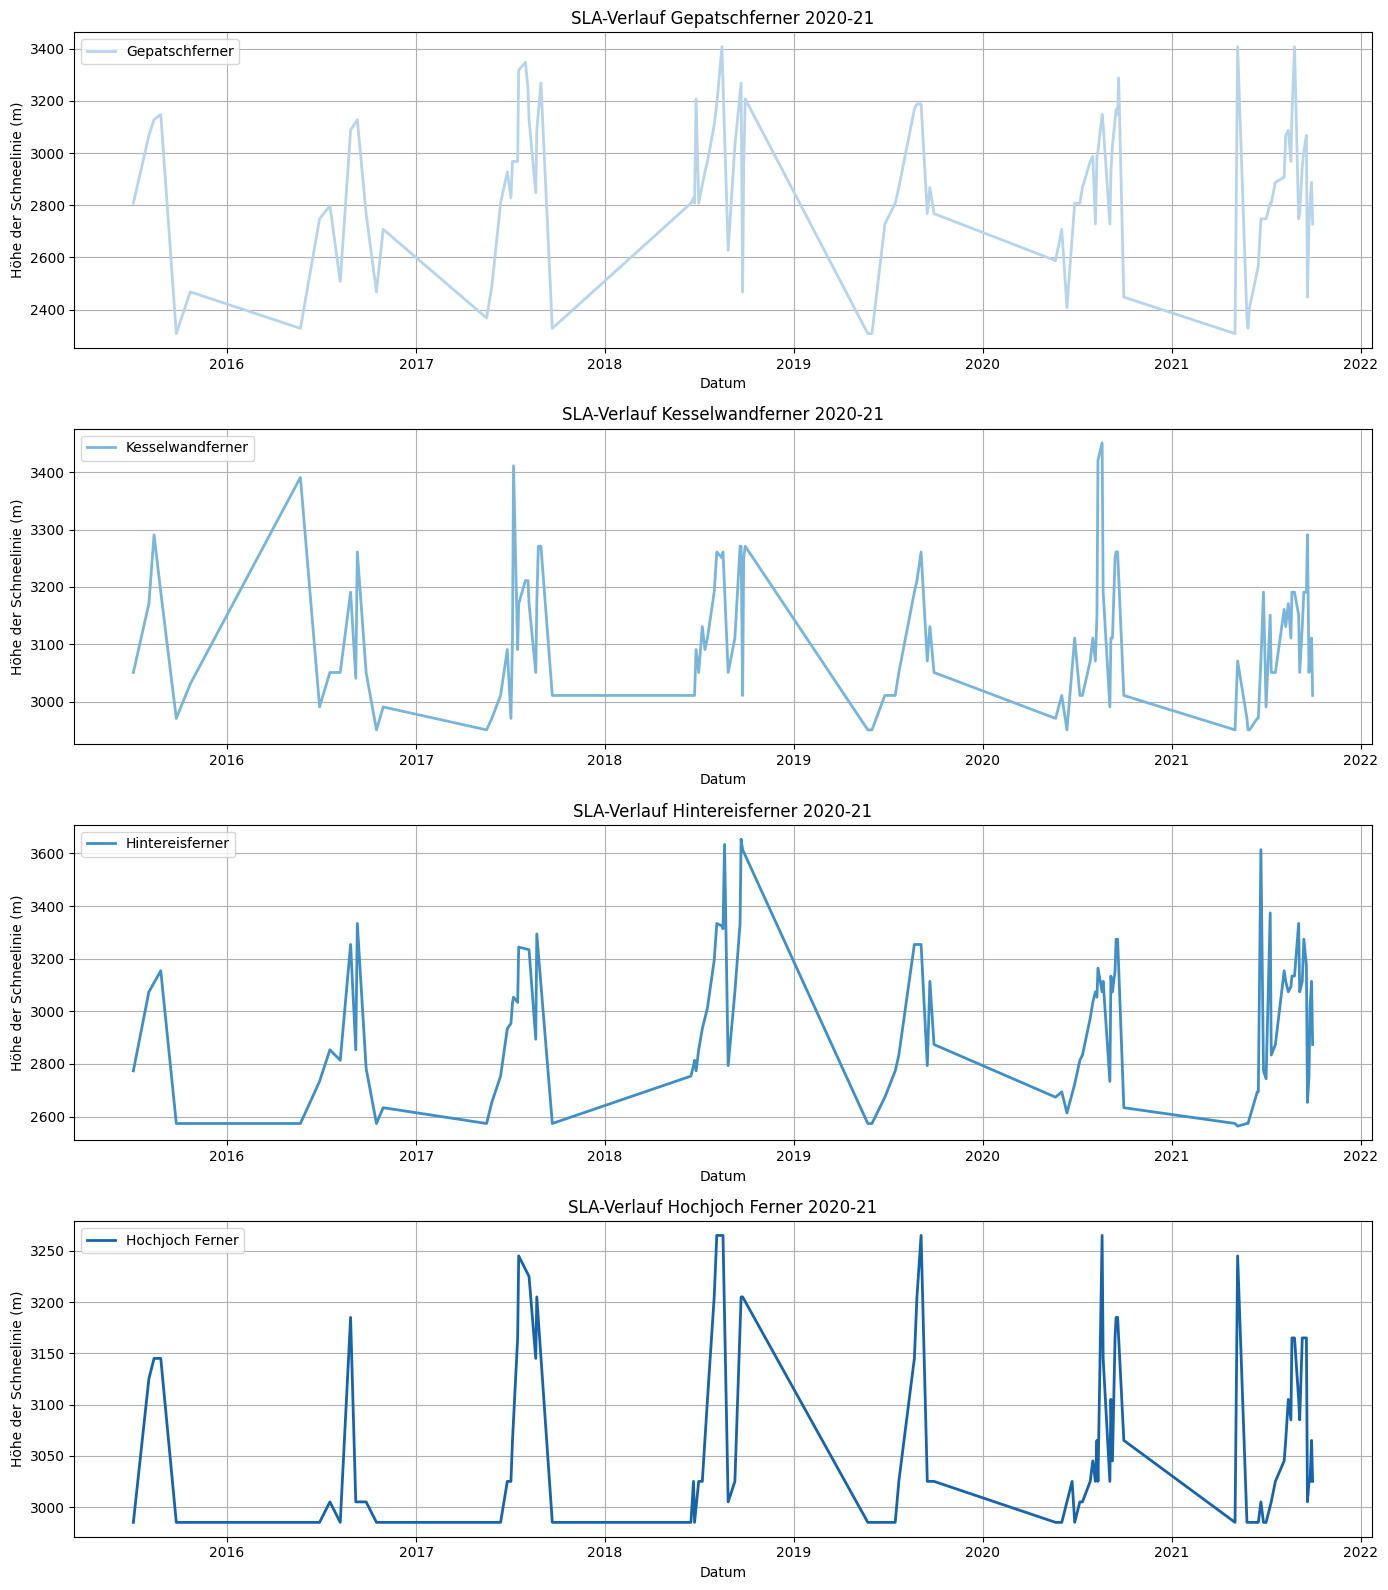

In [23]:
# SLA über Gesamtzeitraum
# Plot für 4 geteilte Grafik mit SLA über Zeit pro Gletscher 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# -------------------------------
# 1) Parameter: Pfade & Gletscher-IDs
# -------------------------------
input_folder = r"C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/all SLA csv"  # Ordner mit CSVs
output_path = r"C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/all SLA csv/SLA_2016-21.png"      # Speicherpfad für die Grafik

# Gletscher-IDs und zugehörige Namen:
gid_to_name = {
    755530: "Gepatschferner",
    755560: "Kesselwandferner",
    755531: "Hintereisferner",
    755612: "Hochjoch Ferner"
}
gids = list(gid_to_name.keys())

# -------------------------------
# 2) Farben definieren
# -------------------------------
num_glaciers = len(gids)
blues = cm.Blues(np.linspace(0.3, 0.8, num_glaciers))  # 4 Blautöne von hell bis dunkel

# -------------------------------
# 3) Subplots erstellen
# -------------------------------
# 4 Subplots untereinander, aber breiter (für mehr Übersichtlichkeit)
fig, axs = plt.subplots(num_glaciers, 1, figsize=(14, 4 * num_glaciers))  # Breite angepasst, Höhe reduziert

# Wenn nur ein Gletscher vorhanden ist, wird axs zu einem einzelnen Ax-Objekt, daher müssen wir es in eine Liste umwandeln.
if num_glaciers == 1:
    axs = [axs]

# Iteriere über alle Gletscher
for i, gid in enumerate(gids):
    csv_file = os.path.join(input_folder, f"snowline_results_{gid}.csv")

    # CSV einlesen
    df = pd.read_csv(csv_file)

    # Zeilen mit "No SLA found" ausschließen
    df = df[df["SLA Range (m)"] != "No SLA found"]
    if df.empty:
        print(f"Keine gültigen SLA-Daten für Gletscher {gid} in '{csv_file}'.")
        continue

    # SLA-Min / -Max extrahieren
    df["SLA_min"] = df["SLA Range (m)"].str.split(" - ").str[0].astype(float)
    df["SLA_max"] = df["SLA Range (m)"].str.split(" - ").str[1].astype(float)
    df["SLA_mid"] = (df["SLA_min"] + df["SLA_max"]) / 2

    # Datum parsen (Format: YYYYMMDD)
    df["Date"] = pd.to_datetime(df["Date"], format="%Y%m%d")

    # Sortierung nach Datum
    df.sort_values(by="Date", inplace=True)

    # Plotten auf dem jeweiligen Subplot (axs[i])
    axs[i].plot(
        df["Date"], 
        df["SLA_mid"],
        color=blues[i],
        linestyle="-",
        linewidth=2,
        marker=None,
        label=gid_to_name[gid]  # Statt Gletscher-ID den Namen anzeigen
    )

    # Details für jedes Subplot
    axs[i].set_xlabel("Datum")
    axs[i].set_ylabel("Höhe der Schneelinie (m)")
    axs[i].set_title(f"SLA-Verlauf {gid_to_name[gid]} 2020-21")
    axs[i].grid(True)
    
    # Position der Legende anpassen (links oben)
    axs[i].legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=10)

# -------------------------------
# 4) Diagramm anpassen & Speichern
# -------------------------------
plt.tight_layout()  # Verhindert, dass die Subplots überlappen

# Grafik speichern (z. B. als PNG in hoher Auflösung)
plt.savefig(output_path, dpi=300)

# Optional: Plot anzeigen
plt.show()



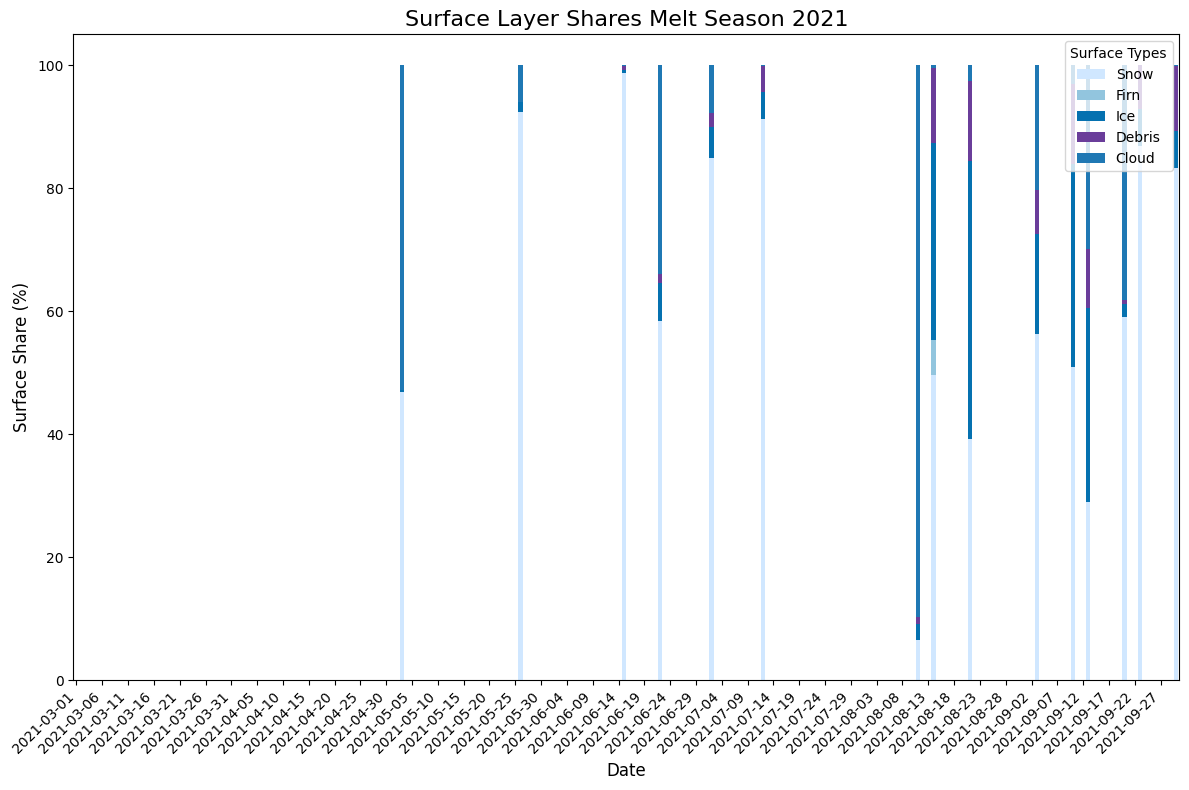

In [1]:
# Säulendiagramm zur Darstellung der Oberflächenanteile in %

import os
import re
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definiere den Pfad zum Ordner mit den Schneeklassifikations-Rastern
input_folder = "C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2021/GLF_2021_T32TPS"  # Pfad anpassen

# Definiere den Pfad zur Gletschermaske
mask_file =  "C:/Users/anne_/Desktop/Anne/ENVEO/glaciermask.tiff"  # Gletschermaske

# Gletschermaske einlesen
with rasterio.open(mask_file) as src:
    glacier_mask = src.read(1)  # Erstes Rasterband

# Erstelle eine Liste mit allen Tagen vom 01.03. bis 30.09.
dates = pd.date_range(start="2021-03-01", end="2021-09-30", freq='D')

# Initialisiere eine Liste zur Speicherung der Ergebnisse
results = []

# Iteriere über alle Tage im Zeitraum
for date in dates:
    # Datum im Format YYYYMMDD
    date_str = date.strftime('%Y%m%d')

    # Suchen der entsprechenden .tif Datei im Ordner und extrahiere Datum aus dem Dateinamen
    raster_files = [f for f in os.listdir(input_folder) if re.search(r'GLF_S2A_MSIL1C_' + re.escape(date_str), f)]
    
    if raster_files:
        # Nimm die erste passende Datei (falls mehrere vorhanden sind)
        raster_file = raster_files[0]
        input_path = os.path.join(input_folder, raster_file)

        # Rasterdatei einlesen
        with rasterio.open(input_path) as src:
            band_data = src.read(1)  # Nur das erste Band einlesen

            # Initialisiere eine leere Matrix für die Oberflächenschichten
            surface_layer = np.zeros_like(glacier_mask, dtype=np.int32)

            # Iteriere über die Oberflächentypen (1 bis 5)
            for i in range(1, 6):  # Schneetypen: 1 = snow, 2 = firn, 3 = ice, 4 = debris, 5 = cloud
                # Maskiere den Gletscherbereich
                mask = (glacier_mask == 1) & (band_data == i)
                surface_layer[mask] = i  # Setze den Oberflächentyp

            # Berechne die Flächenanteile für jeden Oberflächentyp
            total_area = np.sum(glacier_mask == 1)  # Gesamtfläche des Gletschers
            layer_1_area = np.sum(surface_layer == 1)  # Schnee
            layer_2_area = np.sum(surface_layer == 2)  # Firn/Altschnee
            layer_3_area = np.sum(surface_layer == 3)  # Eis
            layer_4_area = np.sum(surface_layer == 4)  # Schutt
            layer_5_area = np.sum(surface_layer == 5)  # Wolken

            # Prozentsatz berechnen
            layer_1_percentage = (layer_1_area / total_area) * 100 if total_area > 0 else 0
            layer_2_percentage = (layer_2_area / total_area) * 100 if total_area > 0 else 0
            layer_3_percentage = (layer_3_area / total_area) * 100 if total_area > 0 else 0
            layer_4_percentage = (layer_4_area / total_area) * 100 if total_area > 0 else 0
            layer_5_percentage = (layer_5_area / total_area) * 100 if total_area > 0 else 0

            # Ergebnisse speichern
            results.append({
                "Date": date.strftime("%Y-%m-%d"),
                "Snow": layer_1_percentage,
                "Firn": layer_2_percentage,
                "Ice": layer_3_percentage,
                "Debris": layer_4_percentage,
                "Cloud": layer_5_percentage
            })
    else:
        # Wenn keine Datei vorhanden ist, fügen wir eine leere Zeile ein
        results.append({
            "Date": date.strftime("%Y-%m-%d"),
            "Snow": np.nan,
            "Firn": np.nan,
            "Ice": np.nan,
            "Debris": np.nan,
            "Cloud": np.nan
        })

# Konvertiere die Ergebnisse in einen DataFrame
layer_surface_shares = pd.DataFrame(results)

# Setze das Datum als Index
layer_surface_shares.set_index("Date", inplace=True)

# # Plot: Gestapeltes Säulendiagramm
# fig, ax = plt.subplots(figsize=(12, 8))
# layer_surface_shares.plot(kind="bar", stacked=True, ax=ax, color=["#d0e7ff", "#92c5de", "#0571b0", "#6a3d9a", "#1f78b4"])

# # Diagramm anpassen
# ax.set_title("Surface Layer Shares Melt Season 2015", fontsize=16)
# ax.set_xlabel("Date", fontsize=12)
# ax.set_ylabel("Surface Share (%)", fontsize=12)
# ax.legend(title="Surface Types", loc="upper right")
# ax.set_xticks(range(0, len(layer_surface_shares.index), 5))  # Zeige jeden 5. Tag
# ax.set_xticklabels(layer_surface_shares.index[::5], rotation=45, ha="right")

# plt.tight_layout()
# plt.savefig("Surface_Layer_Shares_Melt_Season_2015.png")
# plt.show()


#### Breitere Säulen

# Plot: Gestapeltes Säulendiagramm mit breiteren Säulen
fig, ax = plt.subplots(figsize=(12, 8))
layer_surface_shares.plot(kind="bar", stacked=True, ax=ax, color=["#d0e7ff", "#92c5de", "#0571b0", "#6a3d9a", "#1f78b4"], width=0.8)  # width auf 0.8 setzen

# Diagramm anpassen
ax.set_title("Surface Layer Shares Melt Season 2021", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Surface Share (%)", fontsize=12)
ax.legend(title="Surface Types", loc="upper right")
ax.set_xticks(range(0, len(layer_surface_shares.index), 5))  # Zeige jeden 5. Tag
ax.set_xticklabels(layer_surface_shares.index[::5], rotation=45, ha="right")

plt.tight_layout()
plt.savefig("C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2021/Surface_Layer_Shares_Melt_Season_2021.png")
plt.show()


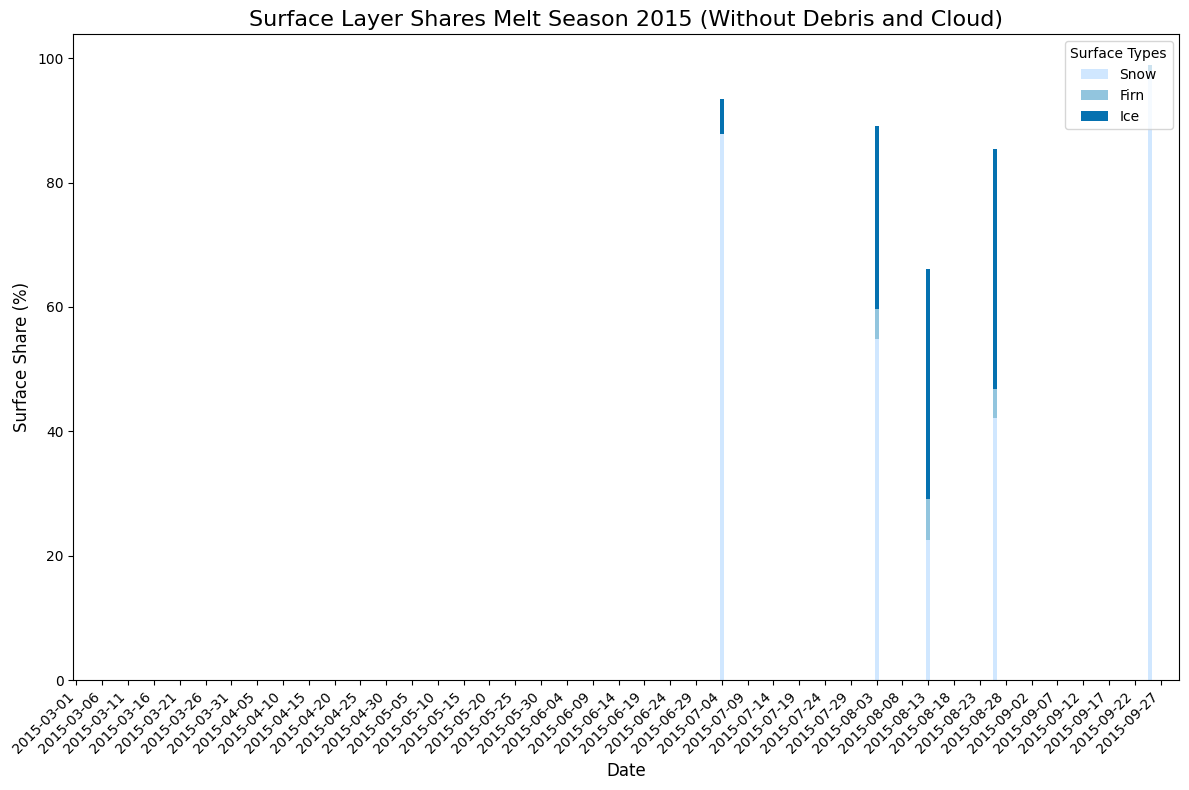

In [45]:
# Grafik nochmal nur mit Schnee, Firn, Eis

import os
import re
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definiere den Pfad zum Ordner mit den Schneeklassifikations-Rastern
input_folder = "C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2015/GLF_2015_T32TPS"  # Pfad anpassen

# Definiere den Pfad zur Gletschermaske
mask_file =  "C:/Users/anne_/Desktop/Anne/ENVEO/glaciermask.tiff"  # Gletschermaske

# Gletschermaske einlesen
with rasterio.open(mask_file) as src:
    glacier_mask = src.read(1)  # Erstes Rasterband

# Erstelle eine Liste mit allen Tagen vom 01.03. bis 30.09.
dates = pd.date_range(start="2015-03-01", end="2015-09-30", freq='D')

# Initialisiere eine Liste zur Speicherung der Ergebnisse
results = []

# Iteriere über alle Tage im Zeitraum
for date in dates:
    # Datum im Format YYYYMMDD
    date_str = date.strftime('%Y%m%d')

    # Suchen der entsprechenden .tif Datei im Ordner und extrahiere Datum aus dem Dateinamen
    raster_files = [f for f in os.listdir(input_folder) if re.search(r'GLF_S2A_MSIL1C_' + re.escape(date_str), f)]
    
    if raster_files:
        # Nimm die erste passende Datei (falls mehrere vorhanden sind)
        raster_file = raster_files[0]
        input_path = os.path.join(input_folder, raster_file)

        # Rasterdatei einlesen
        with rasterio.open(input_path) as src:
            band_data = src.read(1)  # Nur das erste Band einlesen

            # Initialisiere eine leere Matrix für die Oberflächenschichten
            surface_layer = np.zeros_like(glacier_mask, dtype=np.int32)

            # Iteriere nur über die relevanten Oberflächentypen: Snow, Firn, Ice (1, 2, 3)
            for i in range(1, 4):  # Schneetypen: 1 = snow, 2 = firn, 3 = ice
                # Maskiere den Gletscherbereich
                mask = (glacier_mask == 1) & (band_data == i)
                surface_layer[mask] = i  # Setze den Oberflächentyp

            # Berechne die Flächenanteile für jeden Oberflächentyp
            total_area = np.sum(glacier_mask == 1)  # Gesamtfläche des Gletschers
            layer_1_area = np.sum(surface_layer == 1)  # Schnee
            layer_2_area = np.sum(surface_layer == 2)  # Firn/Altschnee
            layer_3_area = np.sum(surface_layer == 3)  # Eis

            # Prozentsatz berechnen
            layer_1_percentage = (layer_1_area / total_area) * 100 if total_area > 0 else 0
            layer_2_percentage = (layer_2_area / total_area) * 100 if total_area > 0 else 0
            layer_3_percentage = (layer_3_area / total_area) * 100 if total_area > 0 else 0

            # Ergebnisse speichern (nur für Snow, Firn und Ice)
            results.append({
                "Date": date.strftime("%Y-%m-%d"),
                "Snow": layer_1_percentage,
                "Firn": layer_2_percentage,
                "Ice": layer_3_percentage
            })
    else:
        # Wenn keine Datei vorhanden ist, fügen wir eine leere Zeile ein
        results.append({
            "Date": date.strftime("%Y-%m-%d"),
            "Snow": np.nan,
            "Firn": np.nan,
            "Ice": np.nan
        })

# Konvertiere die Ergebnisse in einen DataFrame
layer_surface_shares = pd.DataFrame(results)

# Setze das Datum als Index
layer_surface_shares.set_index("Date", inplace=True)

# Plot: Gestapeltes Säulendiagramm mit nur den Klassen Snow, Firn, Ice
fig, ax = plt.subplots(figsize=(12, 8))
layer_surface_shares.plot(kind="bar", stacked=True, ax=ax, color=["#d0e7ff", "#92c5de", "#0571b0"], width=0.8)  # Breitere Säulen

# Diagramm anpassen
ax.set_title("Surface Layer Shares Melt Season 2015 (Without Debris and Cloud)", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Surface Share (%)", fontsize=12)
ax.legend(title="Surface Types", loc="upper right")
ax.set_xticks(range(0, len(layer_surface_shares.index), 5))  # Zeige jeden 5. Tag
ax.set_xticklabels(layer_surface_shares.index[::5], rotation=45, ha="right")

plt.tight_layout()
plt.savefig("C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2015/Surface_Layer_Shares_Melt_Season_2015_Without_Debris_Cloud.png")
plt.show()


In [3]:
# Cryolayer Abbildung

import os
import re
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import geopandas as gpd
from rasterio.mask import mask
# Definiere den Ordnerpfad zum Input (Rasterdateien)
input_folder = "C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2019/GLF_2019_T32TPS"  # Ordner mit Rasterdateien

# Definiere den Ordnerpfad zum Output (für die gespeicherten Plots)
output_folder = "C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2019"  # Ordner für gespeicherte Bilder

# Definiere den Pfad zum Shapefile mit den Gletscherumrissen (falls erforderlich)

aoi_shapefile_path = "C:/Users/anne_/Desktop/Anne/ENVEO/aoi.shp"  # Shapefile der AOI (Area of Interest)


# Lade das Shapefile der AOI
aoi_gdf = gpd.read_file(aoi_shapefile_path)

# Iteriere über alle .tif Dateien im Eingabeordner
for filename in os.listdir(input_folder):
    if filename.endswith(".tif") and "GLF_S2A_MSIL1C_" in filename:
        # Extrahiere das Datum im Format YYYYMMDD aus dem Dateinamen
        match = re.search(r'GLF_S2A_MSIL1C_(\d{8})', filename)
        if match:
            date_str = match.group(1)
            input_path = os.path.join(input_folder, filename)

            # Lese das Raster
            with rasterio.open(input_path) as src:
                # Maskiere das Raster mit dem AOI-Shapefile
                aoi_geom = aoi_gdf.geometry.values  # Geometrie aus dem AOI-Shapefile holen
                out_image, out_transform = mask(src, aoi_geom, crop=True)  # Zuschneiden

                # Initialisiere eine leere Matrix für die kombinierte Schicht
                band_data = out_image[0]  # Nur das erste Band verwenden
                combined_layers = np.zeros_like(band_data, dtype=np.int32)

                # Weisen Sie die entsprechenden Werte zu (z.B., 1 = Snow -> Layer 1, 2 = Firn -> Layer 2)
                combined_layers[band_data == 1] = 1  # Snow -> Layer 1
                combined_layers[band_data == 2] = 2  # Firn -> Layer 2
                combined_layers[band_data == 3] = 3  # Clean Ice -> Layer 3
                combined_layers[band_data == 4] = 4  # Debris -> Layer 4
                combined_layers[band_data == 5] = 5  # Cloud -> Layer 5
                combined_layers[(band_data == 0) | (band_data == 255)] = 0  # Unclassified & No Data -> No Data

                # Erstelle Farbskala und Kategoriegrenzen mit debis in hellgrau (#d3d3d3) und anderen Farben
                cmap = ListedColormap([
                    "#ffffff",  # No Data
                    "#d0e7ff",  # Snow
                    "#92c5de",  # Firn
                    "#053061",  # Clean Ice #0571b0
                    "#b0b0b0",  # Debris (Hellgrau)  "#d0e7ff", "#92c5de", "#0571b0", "#053061"
                    "#1f78b4"   # Cloud
                ])
                bounds = [0, 1, 2, 3, 4, 5]  # Kategorien: 0 = No Data, 1 = Snow, 2 = Firn, 3 = Ice, 4 = Debris, 5 = Cloud
                norm = BoundaryNorm(bounds, cmap.N)

                # Plot erstellen
                fig, ax = plt.subplots(figsize=(10, 8))
                im = ax.imshow(combined_layers, cmap=cmap, norm=norm)

                # Legende und Beschriftungen hinzufügen
                cbar = plt.colorbar(im, ax=ax, ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], orientation='vertical', pad=0.02)
                cbar.ax.set_yticklabels(['No Data', 'Snow', 'Firn/Old Snow', 'Clean Ice', 'Debris', 'Cloud'])
                cbar.set_label('Snow Layer Classification')

                # Titel und Achsenbeschriftungen
                ax.set_title(f"Combined Snow Layer Surface on {date_str}", fontsize=16)
                ax.set_xlabel('X')
                ax.set_ylabel('Y')

                # Plot speichern
                output_file = os.path.join(output_folder, f"Combined_Layers_{date_str}.png")
                plt.tight_layout()
                plt.savefig(output_file)
                plt.close()

            print(f"Grafik für {filename} gespeichert als {output_file}")


Grafik für GLF_S2A_MSIL1C_20190524.tif gespeichert als C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2019\Combined_Layers_20190524.png
Grafik für GLF_S2A_MSIL1C_20190626.tif gespeichert als C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2019\Combined_Layers_20190626.png
Grafik für GLF_S2A_MSIL1C_20190716.tif gespeichert als C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2019\Combined_Layers_20190716.png
Grafik für GLF_S2A_MSIL1C_20190723.tif gespeichert als C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2019\Combined_Layers_20190723.png
Grafik für GLF_S2A_MSIL1C_20190822.tif gespeichert als C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2019\Combined_Layers_20190822.png
Grafik für GLF_S2A_MSIL1C_20190904.tif gespeichert als C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2019\Combined_Layers_20190904.png
Grafik für GLF_S2A_MSIL1C_20190921.tif gespeichert als C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2019\Combined_Layers_20190921.png


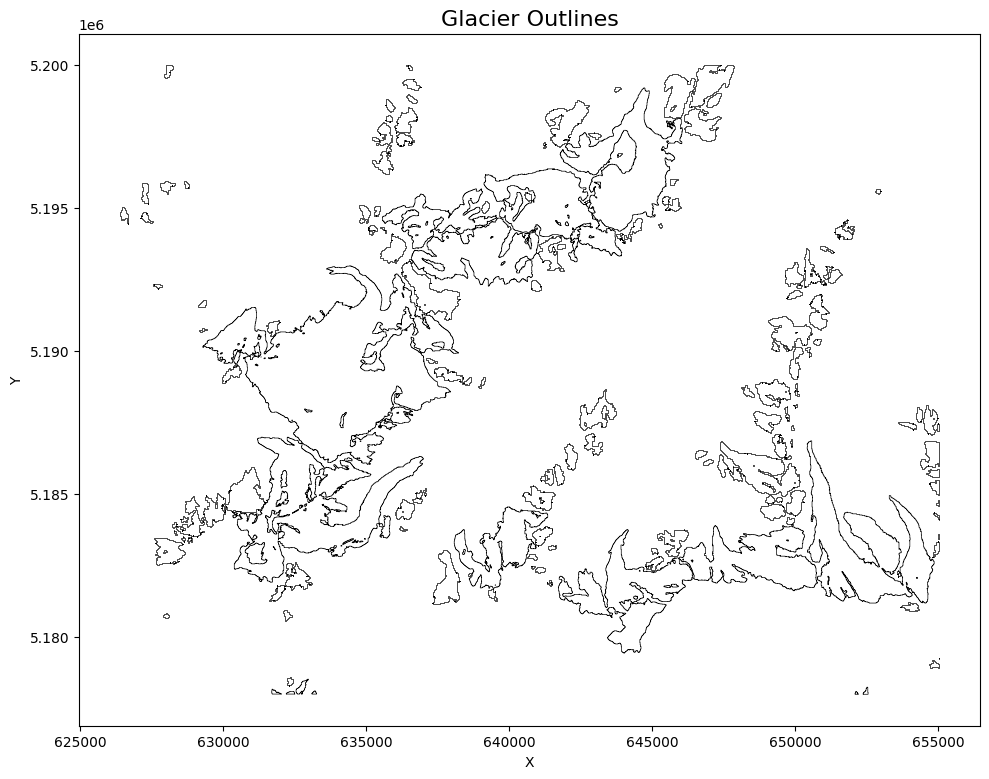

In [13]:
# Gletscherumrisse
import geopandas as gpd
import matplotlib.pyplot as plt

# Pfad zum Gletscherumriss-Shapefile
glacier_shapefile_path = "C:/Users/anne_/Desktop/Anne/ENVEO/gletscherumrisse.shp"

# Lade das Shapefile der Gletscherumrisse mit GeoPandas
glacier_gdf = gpd.read_file(glacier_shapefile_path)

# Optional: Setze sicher, dass das Shapefile im richtigen CRS vorliegt (EPSG:32632)
glacier_gdf = glacier_gdf.to_crs(epsg=32632)

# Erstelle den Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot die Gletscherumrisse ohne Füllung und mit dünnen schwarzen Linien
glacier_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5)

# Setze Titel und Achsenbeschriftungen
ax.set_title('Glacier Outlines', fontsize=16)
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Zeige die Abbildung an
plt.tight_layout()
plt.show()


Raster CRS: EPSG:32632
Raster Bounding Box: BoundingBox(left=622820.0, bottom=5178020.0, right=654980.0, top=5200530.0)
Shapefile CRS: EPSG:32632
CRS des Shapefiles stimmt mit dem Raster-CRS überein.
Shapefile Bounding Box: [ 603010. 5100080.  668040. 5199990.]
Das Shapefile und das Raster stimmen in der räumlichen Ausrichtung nicht überein.


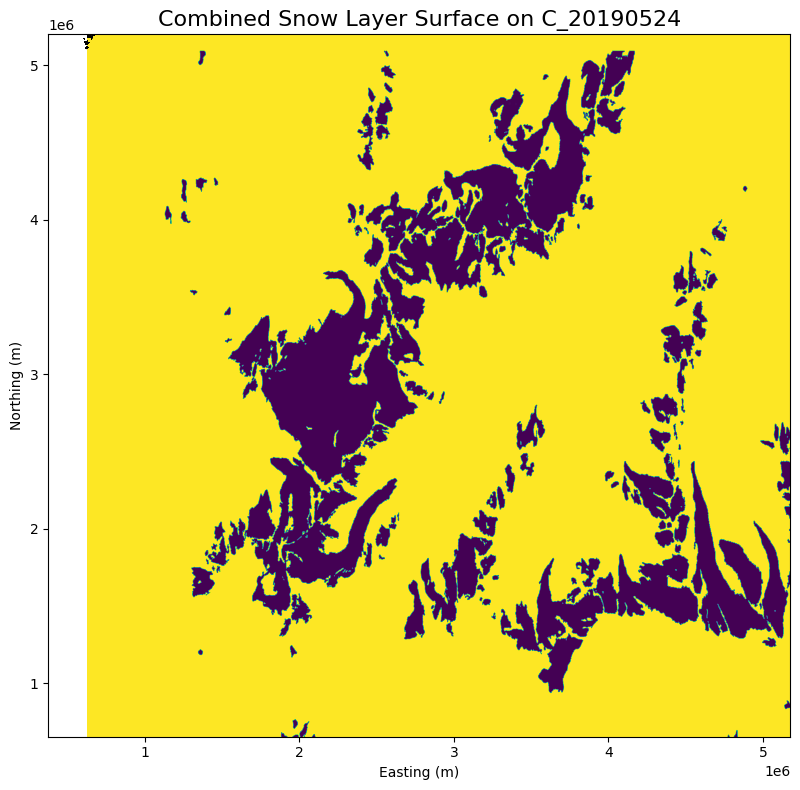

In [11]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Pfad zum Raster und Shapefile
raster_file_path = "C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2019/GLF_2019_T32TPS/GLF_S2A_MSIL1C_20190524.tif"
shapefile_path = "C:/Users/anne_/Desktop/Anne/ENVEO/gletscherumrisse_enveo.shp"

# Lese das Raster
with rasterio.open(raster_file_path) as src:
    band_data = src.read(1)  # Lese das erste Band des Rasters
    
    # Räumliche Informationen des Rasters ausgeben
    raster_crs = src.crs
    raster_bounds = src.bounds  # gibt die Ausdehnung des Rasters zurück (minx, miny, maxx, maxy)
    print(f"Raster CRS: {raster_crs}")
    print(f"Raster Bounding Box: {raster_bounds}")

# Lade das Shapefile der Gletscherumrisse
glacier_gdf = gpd.read_file(shapefile_path)

# Überprüfe das CRS des Shapefiles und passe es ggf. an
print(f"Shapefile CRS: {glacier_gdf.crs}")

# Überprüfe, ob das CRS des Shapefiles mit dem Raster-CRS übereinstimmt
if glacier_gdf.crs != raster_crs:
    print("CRS des Shapefiles stimmt nicht mit dem Raster-CRS überein. Umwandlung erforderlich.")
    glacier_gdf = glacier_gdf.to_crs(raster_crs)
    print(f"Shapefile CRS nach Umwandlung: {glacier_gdf.crs}")
else:
    print("CRS des Shapefiles stimmt mit dem Raster-CRS überein.")

# Ausgabe der Bounding Box des Shapefiles
shapefile_bounds = glacier_gdf.total_bounds  # gibt die Ausdehnung des Shapefiles zurück (minx, miny, maxx, maxy)
print(f"Shapefile Bounding Box: {shapefile_bounds}")

#  Überprüfe, ob die Bounding Box des Shapefiles mit der des Rasters übereinstimmt
if (shapefile_bounds[0] >= raster_bounds[0] and shapefile_bounds[2] <= raster_bounds[2] and
    shapefile_bounds[1] >= raster_bounds[1] and shapefile_bounds[3] <= raster_bounds[3]):
    print("Shapefile und Raster sind räumlich korrekt ausgerichtet.")
else:
    print("Das Shapefile und das Raster stimmen in der räumlichen Ausrichtung nicht überein.")

# Erstelle den Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Zuerst das Raster plotten
with rasterio.open(raster_file_path) as src:
    im = ax.imshow(band_data, cmap="viridis", extent=src.bounds)

# Füge das Shapefile hinzu, falls es im richtigen CRS ist
glacier_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5)

# Titel und Achsenbeschriftungen
ax.set_title(f"Combined Snow Layer Surface on {raster_file_path[-14:-4]}", fontsize=16)  # Datum im Titel basierend auf dem Dateinamen
ax.set_xlabel('Easting (m)')  # UTM X-Achse
ax.set_ylabel('Northing (m)')  # UTM Y-Achse

# Plot anpassen und anzeigen
plt.tight_layout()
plt.show()

In [15]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Pfad zum Raster und Shapefile
raster_file_path = "C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/2019/GLF_2019_T32TPS/GLF_S2A_MSIL1C_20190524.tif"
shapefile_path = "C:/Users/anne_/Desktop/Anne/ENVEO/gletscherumrisse_esa.shp"



# Lese das Raster
with rasterio.open(raster_file_path) as src:
    band_data = src.read(1)  # Lese das erste Band des Rasters
    
    # Erstelle eine Farbskala für das Raster
    cmap = ListedColormap(["#ffffff", "#d0e7ff", "#92c5de", "#0571b0", "#6a3d9a", "#1f78b4"])  # Farben definieren
    bounds = [0, 1, 2, 3, 4, 5]  # Kategorien: 0 = No Data, 1 = Snow, 2 = Firn, 3 = Ice, 4 = Debris, 5 = Cloud
    norm = BoundaryNorm(bounds, cmap.N)

# Lade das Shapefile der Gletscherumrisse
glacier_gdf = gpd.read_file(shapefile_path)

# Stelle sicher, dass das Shapefile im gleichen CRS wie das Raster (EPSG:32632) vorliegt
glacier_gdf = glacier_gdf.to_crs(epsg=32632)

# Erstelle den Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Zuerst das Raster plotten
im = ax.imshow(band_data, cmap=cmap, norm=norm, extent=src.bounds)

# Speichere das Raster zuerst, bevor das Shapefile hinzugefügt wird
plt.savefig('raster_with_no_shapefile.png', bbox_inches='tight', dpi=300)

# Dann das Shapefile der Gletscherumrisse mit transparentem Hintergrund und schwarzen Linien
glacier_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5)

# Speichern der endgültigen Grafik mit Shapefile über dem Raster
plt.savefig('raster_with_shapefile.png', bbox_inches='tight', dpi=300)

# Legende hinzufügen
cbar = plt.colorbar(im, ax=ax, ticks=[0.5, 1.5, 2.5, 3.5, 4.5], orientation='vertical', pad=0.02)
cbar.ax.set_yticklabels(['No Data', 'Snow', 'Firn/Old Snow', 'Clean Ice', 'Debris'])
cbar.set_label('Snow Layer Classification')

# Titel und Achsenbeschriftungen
ax.set_title(f"Combined Snow Layer Surface on {raster_file_path[-14:-4]}", fontsize=16)  # Datum im Titel basierend auf dem Dateinamen
ax.set_xlabel('Easting (m)')  # UTM X-Achse
ax.set_ylabel('Northing (m)')  # UTM Y-Achse

# Plot anpassen und anzeigen
plt.tight_layout()
plt.show()


DataSourceError: Unable to open C:/Users/anne_/Desktop/Anne/ENVEO/gletscherumrisse_esa.shx or C:/Users/anne_/Desktop/Anne/ENVEO/gletscherumrisse_esa.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.